**Importing**

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.sparse.linalg import spsolve

**TASK 1**

Select grayscale image

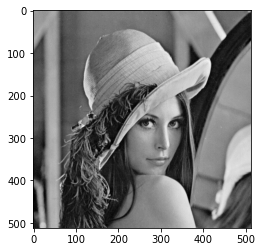

In [5]:
gray_img = cv2.imread("lina.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(gray_img, "gray")
plt.show()

Selecting a region using a polygon

In [6]:
def select_point(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        params[1].append([x, y])
        cv2.circle(params[0], (x, y), 1, (255, 0, 0), 5)
        cv2.imshow('select the points (in order) of the region you want', params[0])

In [7]:
source_task1 = np.copy(gray_img)
params = [source_task1, []]
cv2.imshow('select the points (in order) of the region you want', source_task1)
cv2.setMouseCallback('select the points (in order) of the region you want', select_point, param=params)
cv2.waitKey(0)
cv2.destroyAllWindows()
pts = np.array(params[1])
mask_task1 = np.zeros(source_task1.shape)
cv2.fillConvexPoly(mask_task1, pts, 1)
mask_task1 = 1*mask_task1.astype(np.bool_)

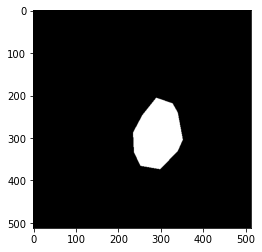

In [8]:
plt.imshow(mask_task1, "gray")
plt.show()

To construct the laplacien matrix (and only for this technical implementation), I admit that (apart from the video of this coursework) I was also inspired by these two resources that I found while searching on Internet how to build this matrix in an efficient way using scipy.sparse:
1. "https://en.wikipedia.org/wiki/Discrete_Poisson_equation"
2. "https://github.com/PPPW/poisson-image-editing/blob/master/poisson_image_editing.ipynb"

In [9]:
def laplacien(n, m):
    "https://en.wikipedia.org/wiki/Discrete_Poisson_equation" 
    D = scipy.sparse.lil_matrix((m, m))
    D.setdiag(-1, -1)
    D.setdiag(4)
    D.setdiag(-1, 1)
    A = scipy.sparse.block_diag([D] * n).tolil()
    A.setdiag(-1, 1*m)
    A.setdiag(-1, -1*m)
    return A

In [10]:
def laplacien_matrix(mask):
    n, m = mask.shape
    A = laplacien(n, m)
    for y in range(1, n - 1):
        for x in range(1, m - 1):
            if mask[y, x] == 0: # We set the block matrix to identity if it is not in the region omega
                # diagonal
                A[x + y * m, x + y * m] = 1 # was 4 before
                # around the diagonal
                A[x + y * m, x + y * m + 1] = 0 # was -1 before
                A[x + y * m, x + y * m - 1] = 0 # was -1 before
                # set the other -1 term
                A[x + y * m, x + y * m + m] = 0 # was -1 before
                A[x + y * m, x + y * m - m] = 0 # was -1 before
    return A.tocsc()

In [11]:
def Poisson_solver(target, mask, b):
    """
    source: source image
    target: image with pixels f*
    mask: binary image containing the region g we would like to take 
    b: the right part of the Poisson Equation: Laplacien(f) = b
    """
    laplacien_m = laplacien_matrix(mask)
    # Solve for x: laplacien_m.x = b
    x = spsolve(laplacien_m, b).reshape((target.shape[0], target.shape[1]))
    x[x > 255] = 255
    x[x < 0] = 0
    x = x.astype(np.uint8)
    return x

Using Equation (2):

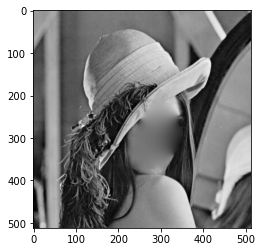

In [12]:
# Laplacien(f) = 0 if mask == True      
b_task1 = np.zeros_like(gray_img.flatten())
# outside the mask:
# f = f* if mask == False
b_task1[mask_task1.flatten() == False] = gray_img.flatten()[mask_task1.flatten() == False]
task1 = Poisson_solver(gray_img, mask_task1, b_task1)
plt.imshow(task1, "gray") 
plt.show()

**Testing the method above in smooth regions:** I selected the cheek in this example, and here is the result:

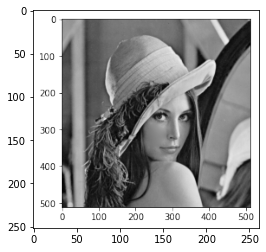

In [13]:
example_smooth = plt.imread("example_smooth.png")
plt.imshow(example_smooth, "gray")
plt.show()

**Testing the method above in regions with edges:** I selected the face in this example, and here is the result:

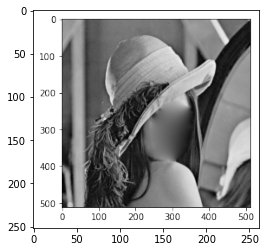

In [11]:
example_edges = plt.imread("example_edges.png")
plt.imshow(example_edges, "gray")
plt.show()

When the size of the selected region increases, the filling becomes more visible for two main reasons:
1. We have more chances to have edges in the region
2. The distribution of pixels inside a big region has more dispersion than in a small size

Here is an example where I selected the face + the hat:

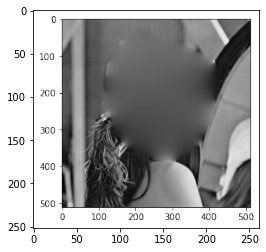

In [41]:
example_facehat = plt.imread("example_facehat.png")
plt.imshow(example_facehat, "gray")
plt.show()

**TASK 2:**

Now we need two pictures

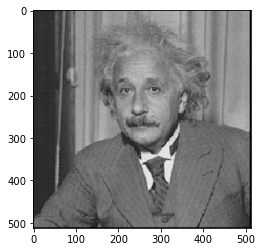

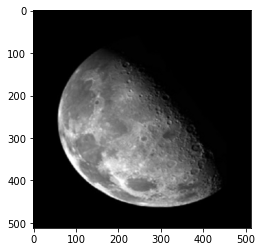

In [14]:
source_task2 = cv2.imread("einstein.png", cv2.IMREAD_GRAYSCALE)
target_task2 = cv2.imread("moon.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(source_task2, "gray")
plt.show()
plt.imshow(target_task2, "gray")
plt.show()

In [15]:
source_task2_cpy = np.copy(source_task2)
params = [source_task2_cpy, []]
cv2.imshow('select the points (in order) of the region you want', source_task2_cpy)
cv2.setMouseCallback('select the points (in order) of the region you want', select_point, param=params)
cv2.waitKey(0)
cv2.destroyAllWindows()
pts = np.array(params[1])
mask_task2 = np.zeros(source_task2_cpy.shape)
cv2.fillConvexPoly(mask_task2, pts, 1)
mask_task2 = 1*mask_task2.astype(np.bool_).astype(np.uint8)
centroid = np.mean(pts, 0)

In [16]:
def blend(image, mask):
        blended = image.copy()  
        blended[mask != 0] = blended[mask != 0]*.5 + 255*.5
        return blended.astype(np.uint8)

In [17]:
def select_where(event, x, y, flags, params):
    """
    params = [image, mask]
    """
    if event == cv2.EVENT_LBUTTONDOWN:
        M = np.float32([[1, 0, x-params[2][0]], [0, 1, y-params[2][1]]])
        params[1] = cv2.warpAffine(params[1], M, params[1].shape[::-1])
        params[-1] = [x-params[2][0], y-params[2][1]] 
        params[2] = [x, y]

Please press the "a" button on your keyboard after selecting with the mouse where you want to put the image

In [18]:
offsets = [0, 0]
params = [target_task2, mask_task2, centroid, offsets]
cv2.namedWindow('putMask')
cv2.setMouseCallback('putMask', select_where, params)
while True:
            cv2.imshow('putMask', blend(target_task2, params[1]))
            if cv2.waitKey(33) == ord('a'):
                break
mask_task2 = params[1]
offsets = params[-1]
cv2.destroyAllWindows()
M = np.float32([[1, 0, offsets[0]], [0, 1, offsets[1]]])
source = cv2.warpAffine(source_task2, M, target_task2.shape[::-1])
target = cv2.warpAffine(target_task2, M, target_task2.shape[::-1])

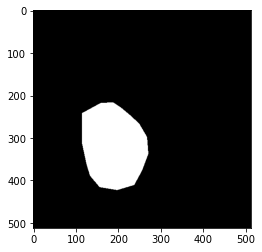

In [19]:
plt.imshow(mask_task2, 'gray')
plt.show()

**Version a:** Importing gradients

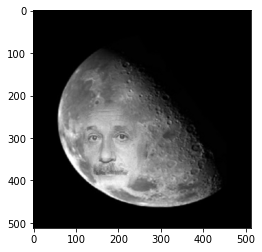

In [20]:
# Laplacien(f) = Laplacien(g) if mask == 1 (we are in omega)    
b_task2_a = laplacien(target_task2.shape[0], target_task2.shape[1]).tocsc().dot(source.flatten())
# outside the mask:
# f = f* if mask == 0 (outside omega)
b_task2_a[mask_task2.flatten() == 0] = target_task2.flatten()[mask_task2.flatten() == 0]
importing_gradient = Poisson_solver(target_task2, mask_task2, b_task2_a)
plt.imshow(importing_gradient, "gray") 
plt.show()

**Version b:** Mixing gradients

We compute the gradients of the images:

In [21]:
kernelx = np.array([[1,0,-1],
                    [1,0,-1],
                    [1,0,-1]])
kernely = kernelx.T
sx = cv2.filter2D(source_task2,cv2.CV_8U,kernelx)
sy = cv2.filter2D(source_task2,cv2.CV_8U,kernely)
gradient_source = np.hypot(sx, sy).astype(np.uint8).T
tx = cv2.filter2D(target_task2,cv2.CV_8U,kernelx)
ty = cv2.filter2D(target_task2,cv2.CV_8U,kernely)
gradient_target = np.hypot(tx, ty).astype(np.uint8).T

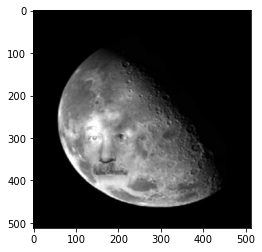

In [22]:
# Laplacien(f) = Laplacien(g)  if gradient(g) >= gradient (f*), else Laplacien(f) = Laplacien(f*) 
laplacien_g = laplacien(target_task2.shape[0], target_task2.shape[1]).tocsc().dot(source.flatten())
laplacien_fstar = laplacien(target_task2.shape[0], target_task2.shape[1]).tocsc().dot(target_task2.flatten())
b_task2_b = np.where(gradient_source.flatten() >= gradient_target.flatten(), laplacien_g, laplacien_fstar)

# f = f* in mask == 0 (outside omega)
b_task2_b[mask_task2.flatten() == 0] = target_task2.flatten()[mask_task2.flatten() == 0]
mixing_gradient = Poisson_solver(target_task2, mask_task2, b_task2_b)
plt.imshow(mixing_gradient, "gray") 
plt.show()

**Task 3:** Repeating task 2a (seemless cloning) with color images

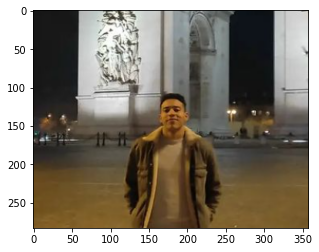

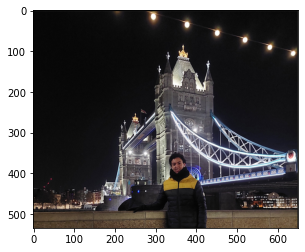

In [23]:
source_task3 = cv2.imread("source.png")
target_task3 = cv2.imread("target.png")
plt.imshow(source_task3[:, :, ::-1])
plt.show()
plt.imshow(target_task3[:, :, ::-1])
plt.show()

In [24]:
source_task3_cpy = np.copy(source_task3)
params = [source_task3_cpy, []]
cv2.imshow('select the points (in order) of the region you want', source_task3_cpy)
cv2.setMouseCallback('select the points (in order) of the region you want', select_point, param=params)
cv2.waitKey(0)
cv2.destroyAllWindows()
pts = np.array(params[1])
mask_task3 = np.zeros(source_task3_cpy.shape[:-1])
cv2.fillConvexPoly(mask_task3, pts, 1)
mask_task3 = 1*mask_task3.astype(np.bool_).astype(np.uint8)
mask_task3_cpy = np.zeros((target_task3.shape[0], target_task3.shape[1]))
mask_task3_cpy[np.where(mask_task3!=0)] = 255
centroid = np.mean(pts, 0)

In [25]:
offsets = [0, 0]
params = [target_task3, mask_task3_cpy, centroid, offsets]
cv2.namedWindow('putMask')
cv2.setMouseCallback('putMask', select_where, params)
while True:
            cv2.imshow('putMask', blend(target_task3, params[1]))
            if cv2.waitKey(33) == ord('a'):
                break
mask_task3 = params[1]
mask_task3[mask_task3 != 0] = 1
offsets = params[-1]
cv2.destroyAllWindows()
M = np.float32([[1, 0, offsets[0]], [0, 1, offsets[1]]])
source_col = cv2.warpAffine(source_task3, M, (target_task3.shape[1], target_task3.shape[0]))

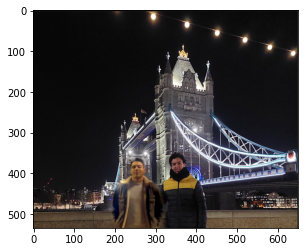

In [26]:
cloning_color = np.copy(target_task3)
for color in range(3):
    # Laplacien(f) = Laplacien(g) like for task2 but we do it for each color now  
    b_task3 = laplacien(target_task3.shape[0], target_task3.shape[1]).tocsc().dot(source_col[:, :, color].flatten())

    b_task3[mask_task3.flatten() == 0] = target_task3[:, :, color].flatten()[mask_task3.flatten() == 0]
    channel = Poisson_solver(target_task3, mask_task3, b_task3)
    cloning_color[:, :, color] = channel
plt.imshow(cloning_color[:, :, ::-1]) 
plt.show()

**Task4:** I choose to implement the local color changes for this task. The goal is to modify the color of my hair on the following image:

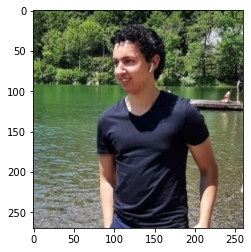

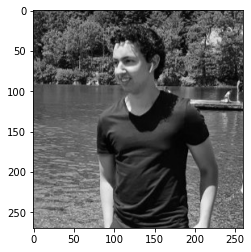

In [27]:
color_me = cv2.imread("me.jpg")
plt.imshow(color_me[:, :, ::-1])
plt.show()
target_task4 = np.copy(color_me)
for y in range(color_me.shape[0]):
    for x in range(color_me.shape[1]):  
        target_task4[y, x, :] = sum(color_me[y, x, :])/3
plt.imshow(target_task4[:, :, ::-1])
plt.show()

In [28]:
source_task4 = np.copy(color_me)
params = [source_task4, []]
cv2.imshow('select the points (in order) of the region you want', source_task4)
cv2.setMouseCallback('select the points (in order) of the region you want', select_point, param=params)
cv2.waitKey(0)
cv2.destroyAllWindows()
pts = np.array(params[1])
mask_task4 = np.zeros(source_task4.shape[:-1])
cv2.fillConvexPoly(mask_task4, pts, 1)
mask_task4 = 1*mask_task4.astype(np.bool_)

Multiplying the RGB channels of the original image by 1.5, 0.5, and 0.5 respectively to form the source image: as stated in the article

In [29]:
for y in range(source_task4.shape[0]):
    for x in range(source_task4.shape[1]):
        if mask_task4[y, x] == 1:
            source_task4[y, x, 0] *= 1.5
            source_task4[y, x, 1] *= .5
            source_task4[y, x, 2] *= .5

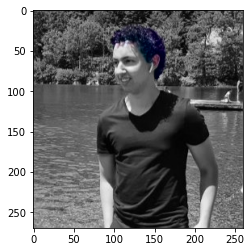

In [30]:
change_color = np.copy(target_task4)
for color in range(3):
    # like for the previous task:
    b_task4 = laplacien(target_task4.shape[0], target_task4.shape[1]).tocsc().dot(color_me[:, :, color].flatten())
 
    b_task4[mask_task4.flatten() == 0] = target_task4[:, :, color].flatten()[mask_task4.flatten() == 0]
    channel = Poisson_solver(target_task4, mask_task4, b_task4)
    change_color[:, :, color] = channel
    
plt.imshow(change_color[:, :, ::-1]) 
plt.show()